In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Basics of Modeling Time

Now that we've introduced time as a concept, let's discuss how to include it in our models. After all, we've spent so much of this course covering how to build various models, it would be quite a shame if we didn't learn how to model time. For this, let's work with the same data as the previous lesson.

In [2]:
# Create a data frame.
learning_progress = pd.DataFrame()

# Add a range of 100 dates starting Jan 1, 2017.
learning_progress['date'] = pd.date_range(start='2017-01-01', periods=100)

# Add linearly increasing knowledge and oscillating confidence.
learning_progress['knowledge'] = np.arange(0, 100)
learning_progress['confidence'] = 10 * np.cos(np.arange(0, 100) * np.pi / 3.5) + np.arange(0, 100)

Now, this is an extremely simple example scenario, and you can easily see the time series trends we're inducing into the data from the code. But how could we model them?

In this case we'll be working with a linear model. It is also worth noting that time series work is often done with least squares linear models and extensions thereof, because of their explanatory power. How things change over time is often a key learning of the model.

## Linear Trends

Perhaps the most intuitive way to deal with time series data is with a simple linear trend. This treats time just like any other variable. Let's say we were trying to explain variance in confidence over time.

That model could look something like this:

In [3]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

# Note that for sklearn we must convert our data to numeric.
X = pd.DataFrame(pd.to_numeric(learning_progress['date']))
Y = learning_progress['confidence']
lm.fit(X, Y)
lm.score(X, Y)

0.9434054498353532

In [4]:
lm.coef_[0]/8.64e+13


1.34447323738161e-28

In [5]:
# Convert coefficient from nanoseconds to days. this seems to be wrong
lm.coef_[0] * 1000000000 * 24 * 60 * 60

1.0036438938124224

So there are a few things to note here. Firstly, sklearn requires all inputs to to be numeric, so you have to convert your timestamps to numeric. `pd.to_numeric` will do the job, converting the column to nanoseconds since January 1, 1970 (also referred to as _epoch time_ in nanoseconds, as typical epoch time is simply in seconds). This still allows for us to do the same linear trend, but we have to do our coefficient interpretation either in nanoseconds or with a conversion.

We could do the same kind of feature engineering on this feature, taking any functional form or normalizing to a starting point.

What does this coefficient mean? While, with every passing day, our confidence seems to go up .005. That gives us an overall trend to our confidence over time.

However, this is only one way we can deal with time.

## Indicators

So far we've only dealt with a _trend_. This means something changing in a functional direction over time. However, when we deal with time a lot of what we're looking for is a pattern or _seasonality_. There are two traditional ways to deal with this.

The first is with _indicators variables_. These are basically dummy variables that show whether you are in a time of year or not.

The simplest way to do this is to create an indicator for every period of the season. This can be an indicator for each day of the week if you're concerned about a weekly cycle. It can be for every month of the year if you're worried about months. It can be for the four literal seasons if that's what fits your data.

The advantage of this is also its disadvantage. You get a coefficient to adjust for every period in your seasonality allowing for you to get a very specified fit, however this does open you up to overfitting.

You want to make sure that you have enough data so that you're not creating a problem for yourself with these kinds of indicators. For example, if you only have one datapoint in each period, you're going to get a perfect fit and a model that is pretty useless.

Let's see how we could do it with the data from before.

Here let's say we want to model confidence in terms of time.

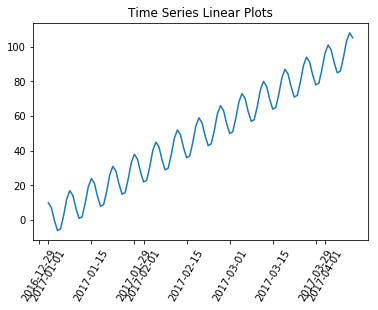

In [6]:
plt.plot(learning_progress.date, learning_progress.confidence)
plt.xticks(rotation=60)
plt.title('Time Series Linear Plots')
plt.show()

This looks to have a weekly pattern too it. Let's model it in terms of two factors: a trend line and a day of the week indicator. To get the indicator, we'll extract the day of the week from our dates and then convert it to a series of dummy variables.

In [7]:
learning_progress['day_of_week'] = learning_progress.date.apply(
    lambda x: str(dt.datetime.weekday(x)))

X = pd.get_dummies(learning_progress.day_of_week)
X['date'] = pd.to_numeric(learning_progress.date) / (1000000000 * 24 * 60 * 60)
Y = learning_progress['confidence']
lm.fit(X, Y)
lm.score(X, Y)

1.0

In [8]:
print(X.columns)
print(lm.coef_)

Index(['0', '1', '2', '3', '4', '5', '6', 'date'], dtype='object')
[ 6.23489802 -2.22520934 -9.00968868 -9.00968868 -2.22520934  6.23489802
 10.          1.        ]


Here we see a series of coefficients for day of the week (with 0 corresponding to Monday). So you can see that mondays have higher confidence than Tuesdays through Friday, with it recovering again over the weekend. On top of that there is a daily trend, with confidence increasing on average 1 unit per day.

All of this has a model score of 1.0, by the way, because this is the exact equation used to create the data, if you discretize the oscillating function.

## Oscillators

We can also use trigonometric functions, specifically sine and cosine. 

These functions are oscillating functions. They have a period and an amplitude.

Text(0.5, 1.0, 'Cosine Function')

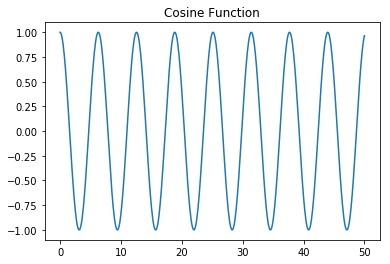

In [9]:
x = np.linspace(0, 50, 500)
plt.plot(x, np.cos(x))
plt.title('Cosine Function')

## A Brief Visit to Trigonometry

Maybe you remember the sine or cosine functions from previous math courses. They're derived from relationships from within triangles. How exactly that works isn't important for our purposes. We're not using them for their trigonometic properties. What's important for us is that they're a regularly repeating oscillating wave where we can control the height of the oscillations and their frequency. To that end, the wave has two features we need to know:

_Amplitude_ is how high the curve goes. For our purposes that is how big its oscillations move from the center. In the image above our amplitude is 1.

_Period_ is how long an oscillation is, or the length of the repeating pattern. Here the period is $2\pi$. 

When working with a linear model and seeing something that oscillates regularly and in a symmetric fashion, it might be useful to use a sine transformation and see if you can draw out periodicity. This can add a regular wiggle or movement up or down, say within a week or a season, to any other linear trends you may have. You have to find the duration of the oscillation yourself before applying the cosine or sine transform.

Let's try it with the data from before again.

In [10]:
X = pd.DataFrame()
X['date'] = pd.to_numeric(learning_progress.date) / (1000000000 * 24 * 60 * 60)

# Note that we're subtracting 17167 from date.
# This is to normalize it so that it starts at zero.
# This aligns the peak of the curve with the start of the cosine function.

X['cos_date'] = np.cos((X.date - 17167) * np.pi / 3.5)
Y = learning_progress['confidence']
lm.fit(X, Y)
lm.score(X, Y)

1.0

In [11]:
lm.coef_

array([ 1., 10.])


So, how do you find the duration of an oscillation? Well the easiest way is to have its period be present in the data. Things that repeat weekly have a weekly period. However, sometimes the period isn't so clear, like say if you see something monthly but it doesn't seem to perfectly line up with a clear start and end at the beginning of the month though you still see a regularly oscillating curve.

For that you'll need [__spectral analysis__](https://en.wikipedia.org/wiki/Spectral_density_estimation). Implementing spectral analysis is beyond the scope of this specialization; in practice you can often attain a reasonable esitmation through indicators and other techniques.

The main value of these trigonometric terms for seasonality is that they avoid overfitting by only offering a single term to match, the amplitude. Perhaps you're also manually estimating period. But other than that there is nowhere near the number of opportunities for overfitting, compared to say 12 indicators for month of the year.